In [2]:
import re
import os
import sys
import json
import dataclasses
from typing import List
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set()

## GIZA++ の出力結果からの分析

In [116]:
fi_data = 'convai2/A3.final.context'
fi_backtrans = 'convai2/_en_train_both_original_no_cands.context'
fi_sim = 'convai2/sbert_sim.context'
fi_back = 'convai2/backtrans.convai2.context.jsonl'

In [48]:
! head convai2/A3.final.context

# Sentence pair (1) source length 20 target length 14 alignment score : 5.37486e-26
調子 は どう ? 調子 に 乗る ため に チーター を 追いかけ てる の 
NULL ({ 2 9 13 14 }) hi ({ }) , ({ }) how ({ 3 }) are ({ }) you ({ }) doing ({ }) ? ({ 4 }) i'm ({ }) getting ({ }) ready ({ }) to ({ }) do ({ }) some ({ }) cheetah ({ 5 6 7 8 10 }) chasing ({ 11 12 }) to ({ }) stay ({ }) in ({ }) shape ({ 1 }) . ({ }) 
# Sentence pair (2) source length 15 target length 8 alignment score : 1.12009e-13
趣味 は 缶詰 と か 削り と か 
NULL ({ 2 }) i ({ }) am ({ }) ! ({ }) for ({ }) my ({ }) hobby ({ 1 }) i ({ }) like ({ }) to ({ }) do ({ }) canning ({ 3 }) or ({ 4 5 7 8 }) some ({ }) whittling ({ 6 }) . ({ }) 
# Sentence pair (3) source length 16 target length 16 alignment score : 4.15985e-29
すごい ね 。 高校 の とき 100 m で 6 位 だっ た の に ! 
NULL ({ 5 9 13 14 15 }) that's ({ 1 }) neat ({ 2 }) . ({ 3 }) when ({ 6 }) i ({ }) was ({ }) in ({ }) high ({ 4 }) school ({ }) i ({ }) placed ({ }) 6th ({ 10 11 }) in ({ }) 100m ({ 7 8 12 }) dash ({ }) ! ({ 16 }) 


In [50]:
results = []

for line in open(fi_data):
    if line.startswith('#'):
        pattern = 'source length ([0-9]+?) target length ([0-9]+?) alignment'
        m = re.compile(pattern).search(line)
        len_src = int(m.groups()[0])
        len_tgt = int(m.groups()[1])
        score = float(line.split(':')[-1])
    elif line.startswith('NULL'):
        txt_src = ' '.join(re.sub('\(.*?\)', '', line).split()[1:])
        results.append({
            'ln_en': len_src,
            'ln_ja': len_tgt,
            'txt_en': txt_src,
            'txt_ja': txt_tgt,
            'aln_score': score,
        })
    else:
        # parsed = parser([line.strip()])[0]
        # txt_tgt = ' '.join([w.surface for w in parsed])
        # content = list(filter(lambda x: x.pos1 in content_word, parsed[0]))
        txt_tgt = line.strip()


In [52]:
df = pd.DataFrame(results)

In [122]:
df_scores = pd.read_json(fi_back, orient='records', lines=True)
df_scores

,BLEU,METEOR,WER,BERTScore
0,0.000000,0.278550,0.700000,0.785934
1,0.000000,0.223848,0.866667,0.603440
2,0.000000,0.224359,0.750000,0.817832
3,0.000000,0.241935,0.947368,0.615849
4,0.143514,0.332000,0.687500,0.716713
...,...,...,...,...
131433,0.000000,0.039683,1.000000,0.648557
131434,0.000000,0.277612,0.714286,0.745941
131435,0.000000,0.102041,0.800000,0.677040
131436,0.000000,0.619835,0.583333,0.624435


In [123]:
df['txt_ren'] = [line.strip() for line in open(fi_backtrans)]
df['sim_score'] = [float(line.strip()) for line in open(fi_sim)]
df['ln_ren'] = df.apply(lambda x: len(x['txt_ren'].split()), axis=1)
df = df[['txt_ja', 'txt_en', 'txt_ren', 'ln_ja', 'ln_en', 'ln_ren', 'aln_score', 'sim_score']]
df = pd.concat([df, df_scores], axis=1)

df.head()

,txt_ja,txt_en,txt_ren,ln_ja,ln_en,ln_ren,aln_score,sim_score,BLEU,METEOR,WER,BERTScore
0,調子 は どう ? 調子 に 乗る ため に チーター を 追いかけ てる の,"hi , how are you doing ? i'm getting ready to ...",how are you? i'm chasing a cheetah to get in s...,14,20,11,5.374860e-26,0.9346,0.000000,0.278550,0.700000,0.785934
1,趣味 は 缶詰 と か 削り と か,i am ! for my hobby i like to do canning or so...,my hobbies are canning and shaving.,8,15,6,1.120090e-13,0.7354,0.000000,0.223848,0.866667,0.603440
2,すごい ね 。 高校 の とき 100 m で 6 位 だっ た の に !,that's neat . when i was in high school i plac...,that's amazing. i was sixth in the 100 meters ...,16,16,12,4.159850e-29,0.9304,0.000000,0.224359,0.750000,0.817832
3,ない 。 で も 好き な 肉 が ある から もっぱら それ しか 食べ ない 。,i do not . but i do have a favorite meat since...,but I only eat meat that I like because there ...,16,19,15,1.747040e-26,0.7465,0.000000,0.241935,0.947368,0.615849
4,特上 カルビ って 言う ん です けど 好き な 食べ物 と か あり ます か ?,i would have to say its prime rib . do you hav...,do you have any favorite food?,16,16,6,3.043530e-29,0.8144,0.143514,0.332000,0.687500,0.716713


#### トークン数について

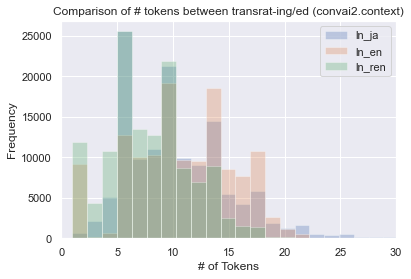

In [90]:
df[['ln_ja', 'ln_en', 'ln_ren']].plot(kind='hist', bins=150, alpha=0.3, xlim=[0,30])
plt.title('Comparison of # tokens between transrat-ing/ed (convai2.context)')
plt.xlabel('# of Tokens')
plt.show()

In [91]:
df[df['ln_en'] > 25].txt_en

12197     a vampire fell in the water . . . a shark bit ...
42652     oh my gosh ! ! ! ! i love boots . i have one p...
57681     good afternoon ! ! ! ! ! ! ! ! ! ! ! ! ! how a...
57682     just on slackware playing quake ! ! ! ! ! ! ! ...
57683     i am a total gamer ! ! ! ! ! ! ! ! ! ! ! ! ! l...
57684     you have pets ? ? ? ! ! ! ! ! ! ! ! me too ! !...
57685     yay ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! farm...
68561     you should ! ! ! its cool . . . . my cat is st...
73431     go ahead ! so , we got some sticks and an old ...
96518     it has been a day , i tell you ! i have four k...
99054     so far , 3 dogs . . and they have 2 pet cats ,...
102579    ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! you ...
120640    i am fine . . . . . cannot imagine 5 kids . . ...
Name: txt_en, dtype: object

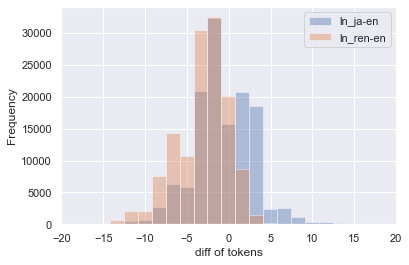

In [197]:
df['ln_ja-en'] = df.apply(lambda x: x['ln_ja']-x['ln_en'], axis=1)
df['ln_ren-en'] = df.apply(lambda x: x['ln_ren']-x['ln_en'], axis=1)
df[['ln_ja-en', 'ln_ren-en']].plot(kind='hist', alpha=0.4, xlim=[-20, 20], bins=150)
plt.xlabel('diff of tokens')
plt.show()

In [93]:
df[abs(df['ln_ja-en']) > 14][['txt_ja', 'txt_en']]

,txt_ja,txt_en
809,あたし も ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ...,mine too ! ! ! ! ! now i can play quake and fe...
1159,おかしい な 職場 で 制服 着せ られ て ブ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~...,"that is funny ! , at work they make me wear a ..."
1683,結婚 する なんて 働き すぎ だ,yes i am married to my job . . . . . i work wa...
1781,ねぇ 、 ハニー 、 ごめん なさい 。,"hey , honey , i am sorry . i want to be there ..."
3226,いく つ か の サッカー の 準備 を する 私 は カウ ボーイズ スタジアム の 近く...,getting ready for some football i live near co...
...,...,...
129093,私 は そこ に すべて の 私 の ショッピング を 行う の が 大好き 、 価格 は ...,"i love doing all my shopping there , prices ar..."
129656,私 は ご飯 と 鶏肉 の よう な 食事 を 調理 する ため に 多く の 時間 を 捧...,i work online so i can dedicate more time to c...
129841,ははははははは ははははははは ははははははは ははははははは ははははははは はははははは...,haha no . i want to be a professional eater .
130827,すごい すごい 。 すごい すごい すごい すごい すごい すごい すごい すごい すごい ...,wow . just wow . i bet you have some great sto...


#### アラインメントスコアについて
- NOTE:
    - トークン長依存
    - ja -> en

In [155]:
### 正規化っぽいこと + 外れ値を除去

df['aln_nrm_score'] = df.apply(lambda x: x['aln_score'] * (10**(x['ln_ja'])), axis=1)
df['aln_nrm_score'].describe()

def clip_outlier(series, bias=1.5):
    q1 = series.quantile(.25)
    q3 = series.quantile(.75)
    iqr = q3 - q1
    outlier_min = q1 - (iqr) * bias
    outlier_max = q3 + (iqr) * bias
    return outlier_min, outlier_max

_min, _max = clip_outlier(df['aln_nrm_score'])
df['aln_outlier'] = (df['aln_nrm_score'] < _min) | (_max < df['aln_nrm_score'])

In [158]:
df[df['aln_outlier']][['txt_ja', 'txt_en']]

,txt_ja,txt_en
7,や あ 今日 は どう ?,"hi , how are you doing today ?"
9,そう です ね 。 お 仕事 は ?,i agree . what do you do for a living ?
19,モヒート と スイカ と キュウリ,i prefer mojitos . watermelon or cucumber .
25,アジア 人 で 髪 が ない の,i'm asian and have no hair .
30,溶接 は ? 家 ?,what do you weld ? houses ?
...,...,...
131416,_ _ SILENCE _ _,__SILENCE__
131424,_ _ SILENCE _ _,__SILENCE__
131431,_ _ SILENCE _ _,__SILENCE__
131434,わあ 私 も 。 好き な 作家 は カサンドラ ・ クレア 。,wow me too . my favorite author is cassandra c...


/Users/miyawaki_shumpei/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:486: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)
/Users/miyawaki_shumpei/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:486: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


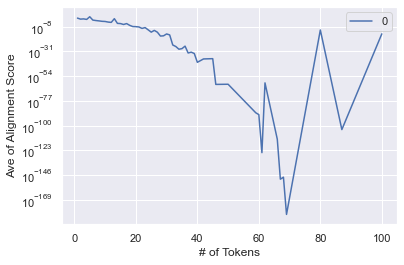

In [95]:
### トークン数-平均スコアのグラフ

score_each_len = {}
for ln in np.sort(df['ln_ja'].unique()):
    score_each_len[int(ln)] = np.mean(df[df['ln_ja'] == ln]['aln_nrm_score'])
    
pd.DataFrame([score_each_len]).transpose().plot(logy=True, ylim=[-1, 0])
plt.xlabel('# of Tokens')
plt.ylabel('Ave of Alignment Score')
plt.show()

In [177]:
df[(df['aln_nrm_score'] < 10e-5) & (df['aln_nrm_score'] >= 10e-31)][['txt_ja']].sample(10)
# df[(df['aln_nrm_score'] < 10e-31)][['txt_ja', 'aln_score', 'aln_outlier']]

,txt_ja
8795,こんにちは デイブ です どう です か ?
18405,楽し そう だ な 基地 に ネット が ある
6934,私 の 良い 謎 の 味 の ケーキ を お 楽しみ ください 。
74585,そうそう 別 に 好き と か そう いう ん じゃ なく て
64184,うん 一人 時間 って いい よ ね
31091,インコ ? カッコ イイ 。 動物 飼っ て ない から 。
43641,長い 週末 を 過ごす の は 、 いつ も いい こと です 。
16563,いい ね ! わたし も 持っ てる 。
65489,で は 他 に 何 を する か
113622,亀 が 好き だ 軍隊 に い た 時 も たくさん 見 た


In [96]:
display(df[(df['aln_nrm_score'] < 10e-20) & (df['aln_nrm_score'] >= 10e-31)][['txt_ja']].head())
display(df[df['aln_nrm_score'] >= 10e-5][['txt_ja']].head())
display(df[df['ln_ja'] == 40][['txt_ja']].head())
display(df[df['ln_ja'] == 50][['txt_ja']].head())

,txt_ja
15,"笑 . 私 は 恥ずかし がり 屋 です , 氷 を 破る ため に 何 で も , そして..."
113,将来 の 夢 は あり ます か ? いつ か プロ と し て 競技 し たり 、 大会 ...
115,週末 は 景色 を 楽しん だり 、 リラックス し たり する ため に カナダ まで 旅...
144,うん 賭け て も いい か な 。 狩り は 好き だ けど 動物 は 殺さ ない 。 そ...
162,夕食 の 準備 を し て い た 私 は 、 いく つ か の ヒット を 完了 する た...


,txt_ja
7,や あ 今日 は どう ?
9,そう です ね 。 お 仕事 は ?
19,モヒート と スイカ と キュウリ
25,アジア 人 で 髪 が ない の
30,溶接 は ? 家 ?


,txt_ja
31732,私 は 私 の 子供 が 彼 ら の 父親 を 持っ て い たら いい の に と 思い ...
45039,わ あー それ は 私 の 5 人 の 子供 の ため に 十分 な 大き さ だ 私 は ...


,txt_ja
33777,すげえ すげえ すげえ すげえ すげえ すげえ すげえ すげえ すげえ すげえ すげえ すげ...
56440,わーい わーい わーい わーい わーい わーい わーい わーい わーい わーい わーい わー...
84192,ハハハ . . . 大丈夫 だろう 。 フッフッ フッフッ フッフッ フッフッ フッフッ フ...


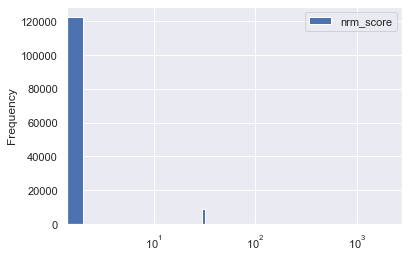

In [97]:
### スコアのヒストグラム

tmp[['nrm_score']].plot(kind='hist', logx=True, bins=1000)

## BackTrans 評価

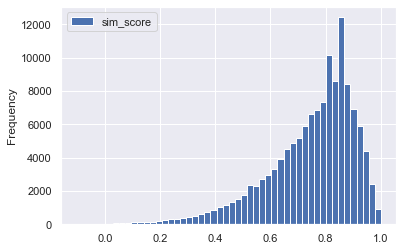

In [98]:
df[['sim_score']].plot(kind='hist', bins=50)

In [182]:
df[['sim_score']].quantile(0.05)

sim_score    0.4274
Name: 0.05, dtype: float64

In [178]:
display(df[df['sim_score'] < 0.4][['txt_en', 'txt_ren', 'txt_ja']])
display(df[df['sim_score'] == 1.0][['txt_en', 'txt_ren', 'txt_ja']])

,txt_en,txt_ren,txt_ja
8,"wow , four sisters . just watching game of thr...",just watching the oza fight.,うわっ 4 姉妹 。 王座 戦 見 てる だけ 。
17,i did too . i do not get along with mine . the...,I don't have any classes.,わたし も うまく いか ない 。 授業 ない 。
33,i bet that it does,what?,⁇ ⁇ ⁇
219,hmmm . i prefer things the old fashioned way ....,I want an old one. you. tell me more about bel...,古い の が いい な 。 お前 。 ベラ の こと もっと 教え て 。 お 願い し ます !
221,you aren't the kids father . vera isn't nice ....,isn't he the father of the child?,子供 の 父親 じゃ ない の ? ベラ 良く ない わ 今 図書 館 に いる の あなた ?
...,...,...,...
131352,what part did you go to ?,"511, where?",どこ に ?
131373,"i can imagine , ever though about doing youtub...",I have a Dell Inspiron 520 that I have install...,私 は それ が 私 の コンピュータ 上 で 起こっ て いる こと だ と 思う 。
131376,not really i stick to make up lol,i'm not particular about makeup for 811.,別 に 化粧 に こだわっ てる わけ じゃ ない よ 笑
131405,he is a good sport about it . what do you do f...,"38.I'm good at sports, but what about play?",スポーツ は 得意 だ けど 遊び は ?


,txt_en,txt_ren,txt_ja
37,you work for a funeral home ?,you work for a funeral home?,葬儀 社 に 勤め てる の ?
66,"hello , how are you today ?","Hello, how are you today?",こんにちは 。 今日 は どう です か ?
111,i work as a general manager at a grocery store...,I work as a general manager at a grocery store...,食料 品 店 で 総 支配 人 と し て 働い てる 。 あなた は ?
125,how many dogs do you have ?,how many dogs do you have?,犬 は 何 匹 飼っ てる ?
460,"hello , how are you today ?","Hello, how are you today?",こんにちは 。 今日 は どう です か ?
...,...,...,...
123039,do you travel a lot ?,do you travel a lot?,旅行 は よく 行く の ?
123103,what was the kid doing ?,what was the kid doing?,子供 は 何 を し て た ?
126213,how many wives do you have ?,how many wives do you have?,奥 さん は 何 人 いる の ?
128031,i'm in the navy .,i'm in the navy.,海軍 に いる


In [131]:
display(df[['BLEU', 'METEOR', 'WER', 'BERTScore']].agg(['min', 'mean', 'max']))

,BLEU,METEOR,WER,BERTScore
min,0.000000,0.000000,0.000000,0.107124
mean,0.045804,0.277872,0.825079,0.682878
max,1.000000,1.154684,100.000000,1.000000


In [149]:
df[['aln_score', 'sim_score', 'METEOR', 'BERTScore']].corr().round(2)

,aln_score,sim_score,METEOR,BERTScore
aln_score,1.00,-0.00,-0.04,-0.01
sim_score,-0.00,1.00,0.42,0.72
METEOR,-0.04,0.42,1.00,0.39
BERTScore,-0.01,0.72,0.39,1.00


In [133]:
# df[['BLEU']].plot(kind='hist', bins=50, xlim=[0, 1.0]) # ミス？
# df[['WER']].plot(kind='hist', bins=50, xlim=[0, 1.0])

(17236, 14)

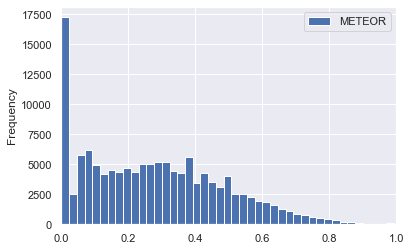

In [161]:
df[['METEOR']].plot(kind='hist', bins=50, xlim=[0, 1.0])

df[df['METEOR'] == 0].shape

In [192]:
df[df['METEOR'] > 0.0][['METEOR']].quantile(0.05)

METEOR    0.059524
Name: 0.05, dtype: float64

In [193]:
display(df[df['METEOR'].round(2) == 0.0][['txt_ja']].sample(5))
display(df[df['METEOR'].round(2) == 0.1][['txt_ja']].sample(5))
display(df[df['METEOR'].round(2) == 0.4][['txt_ja']].sample(5))
display(df[df['METEOR'].round(2) == 0.6][['txt_en', 'txt_ren']].sample(5))
display(df[df['METEOR'].round(2) == 0.8][['txt_en', 'txt_ren']].sample(5))

,txt_ja
128507,_ _ SILENCE _ _
36111,こんにちは 今日 は どう も
68276,サーフィン は ?
33551,バックアップ は ?
15020,寂しい でしょう ね


,txt_ja
20960,IT の 仕事 を し てる の やりがい が ある
63506,よかっ た 、 カリフォルニア 出身 だ 。
34467,今夜 は ちゃんと やっ て ます よ 。
93074,よーし じゃあ 大学 A の 職場 の 奥 さん で も 千 二百 オーバー
25487,まあ そう 思う けど 別 に 悪い こと じゃ ない し


,txt_ja
32748,まあ それ は それ で なかなか クール だ し はい トワイライト シリーズ 好き です
37454,ドイツ 語 以外 は 最高 の バイリンガル 配管 工 だ
25718,い え 支払い が 済む まで 待ち たい
66586,地元 の 短大 で バイト し て ない 時 は ギター 弾い てる 。 お前 ?
10039,インディーズ バンド だ けど 、 最近 は ピンク フロイド と か ドアズミュージック ...


,txt_en,txt_ren
26218,yeah i vacation in the mountains there . i lik...,"3 yeah, i went on vacation in the mountains an..."
65933,yes ! i rode my bike to the last one that was ...,"I rode my bike to the last one, which was in 1..."
100965,i'm 6 feet 10 an i love red,I've got six feet ten an i've got love
111376,no i'm into video games and sports cars,"45 no, i'm into games and sports cars."
106372,marty and biff . ll . i was a big fan of back ...,18 Marty and Biff were big fans of Back to the...


,txt_en,txt_ren
35628,i'm good trying to figure out why i'm not married,i'm trying to figure out why i'm not married.
29292,basketball and football games are in the weeke...,1 Basketball and football games are in the wee...
6164,i party a lot so i like to have a good playlist,"3 I do a lot of parties, so I like to make a g..."
27030,just fighting with my girlfriend as she tells ...,just fight with my girlfriend as one tells me ...
21843,i have a dog and a cat,I have five dogs and a cat.


In [143]:
display(df[df['METEOR'].round(2) == 0.0][['txt_ja']].sample(5))
display(df[df['METEOR'].round(2) == 0.2][['txt_ja']].sample(5))
display(df[df['METEOR'].round(2) == 0.4][['txt_ja']].sample(5))
display(df[df['METEOR'].round(2) == 0.6][['txt_ja']].sample(5))
display(df[df['METEOR'].round(2) == 0.8][['txt_ja']].sample(5))

,txt_ja
117691,_ _ SILENCE _ _
68734,_ _ SILENCE _ _
64143,やあ !
115125,_ _ SILENCE _ _
37517,や あ 今日 は どう ?


,txt_ja
122440,泳ぐ ため に はい 、 その 非常 に 晴れ た 良い 一日 ! ! それ を お 楽しみ...
13144,こんにちは 。 事前 に 申し訳 あり ませ ん が 、 私 の 英語 は それ ほど 素晴...
34706,冗談 だろ ! で も おなら は がん より まし だ よ 。
36619,お 仕事 は ?
96171,見せ て 博士 が 見 たい 写真 を 送っ て


,txt_ja
26306,やあ 。 男 です か 女 です か ?
42362,バンド の 練習 に 行っ て 明日 ライブ が ある ん だ
126785,過去 の 文明 の 遺跡 が 多く 残っ て いる
110810,桟橋 で ポートレート を 描き 海 が 大好き です
24271,いい ね ! もう すぐ 引退 し たい ワシントン ・ ウィザーズ と 契約 し た ばかり だ


,txt_ja
23063,たま に は みんな も やる ん じゃ ない ?
15777,アラスカ は 初めて だ けど アイス コーヒー は 大好き
21381,猫 を 預け て 一 本 で 行ける か どう か 分から ない 。
20205,ギャンブル 好き で スポーツ 情報 も たくさん 教えよう と し てる ん です 。
122112,いや 大きい 家 で 兄弟 二人 で 育つ なんて 許せ ない 笑


,txt_ja
6762,少なく とも バー は ラップ ミュージック を 再生 し ませ ん 。
70101,私 は 人生 に 良い 見通し を 保つ の が 好き 。
54408,私 も ビデオ ゲーム を プレイ する が 、 ストレス を 解消 する ため に 書い ...
99270,野球 が どんどん 上達 し て
22678,音楽 を 聴く の は 好き です か ?


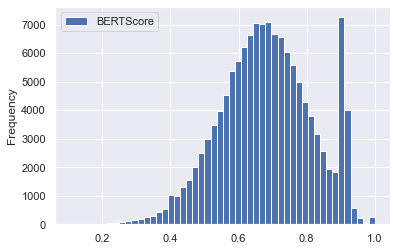

In [150]:
df[['BERTScore']].plot(kind='hist', bins=50)

In [152]:
df[df['BERTScore'] <= 0.3][['BERTScore', 'txt_ja']]

,BERTScore,txt_ja
33,0.224811,⁇ ⁇ ⁇
253,0.242377,結構 です 結構 です
1014,0.282264,ハハハハハハハ ハハハハハハハ ハハハハハハハ ハハハハハハハ ハハハハハハハ ハハハハハハ...
1048,0.260736,必ず いつ か は 必ず 必ず 必ず 必ず
1159,0.243613,おかしい な 職場 で 制服 着せ られ て ブ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~...
...,...,...
129014,0.280491,すごい な 俺 も 。
129361,0.279645,高い の ?
130574,0.282235,ああ ~ また 妊娠 し た 。 今度 は 双子 が 見つかっ た 。
130632,0.252883,ひどい 決断 を 嘆き悲しみ


In [153]:
df[df['BERTScore'] >= 0.9][['BERTScore', 'txt_ja']]

,BERTScore,txt_ja
15,0.960507,"笑 . 私 は 恥ずかし がり 屋 です , 氷 を 破る ため に 何 で も , そして..."
20,0.903697,こんにちは ! グルメ 料理 人 と し て 働い て い ます 。
26,0.957839,ニンジン が 大好き で 、 馬 の よう に ニンジン を 食べ ます 。
37,1.000000,葬儀 社 に 勤め てる の ?
57,0.916064,昔 は よく パーティー し て た
...,...,...
131413,0.903809,あ あ それ は 臭い 、 あなた は しかし 自宅 で 映画 を 見る 必要 が あり ま...
131416,0.912743,_ _ SILENCE _ _
131423,0.906741,めっちゃ かわいい じゃん ! ああ 私 も 娘 が い たら なぁ
131424,0.910020,_ _ SILENCE _ _


# フィルタリング実行
- 単語数: 最終的な前処理で除去するためここでは考えない
- 単語数の差分: 10 以上の差があるものを除去
- アラインメント: 外れ値処理後両側2.5%ずつ
- 類似度: df[['sim_score']].quantile(0.05)
- BERTScore: df[[BERTScore']].quantile(0.05)
- METEOR: df[df['METEOR'] == 0.0]

In [218]:
df['sim_score'].quantile(0.05)

0.4274

In [217]:
vmin, vmax = df[~df['aln_outlier']]['aln_score'].quantile([0.025, 0.975]).values
print(vmin, vmax)

6.224129500000006e-42 1.2906245000000002e-10


In [236]:
tmp = df.copy()

tmp[
    (abs(tmp['ln_ja-en']) >= 10)
    | (abs(tmp['ln_ren-en']) >= 10) \
    | (tmp['aln_score'] <= vmin) \
    | (vmax <= tmp['aln_score']) \
    | (tmp['sim_score'] <= tmp['sim_score'].quantile(0.05)) \
    | (tmp['BERTScore'] <= tmp['BERTScore'].quantile(0.05)) \
    | (tmp['METEOR'] == 0.0) \
].to_csv(open('convai2/del_tgt.tsv', 'w'), sep='\t')

tmp = df.copy()

tmp[~(
    (abs(tmp['ln_ja-en']) >= 10)
    | (abs(tmp['ln_ren-en']) >= 10) \
    | (tmp['aln_score'] <= vmin) \
    | (vmax <= tmp['aln_score']) \
    | (tmp['sim_score'] <= tmp['sim_score'].quantile(0.05)) \
    | (tmp['BERTScore'] <= tmp['BERTScore'].quantile(0.05)) \
    | (tmp['METEOR'] == 0.0) \
)].to_csv(open('convai2/accept_tgt.tsv', 'w'), sep='\t')

In [237]:
! wc -l convai2/del_tgt.tsv
! wc -l convai2/accept_tgt.tsv

42857 convai2/del_tgt.tsv
88583 convai2/accept_tgt.tsv


In [239]:
! shuf -n 100 convai2/del_tgt.tsv > convai2/del_tgt_100.tsv
! shuf -n 100 convai2/accept_tgt.tsv > convai2/accept_tgt_100.tsv

In [240]:
! head -1 convai2/del_tgt.tsv

	txt_ja	txt_en	txt_ren	ln_ja	ln_en	ln_ren	aln_score	sim_score	BLEU	METEOR	WER	BERTScore	aln_nrm_score	aln_outlier	ln_ja-en	ln_ren-en
